In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from datetime import datetime

In [2]:
df= pd.read_csv('/content/Traffic_Collision_Data_from_2010_to_Present.csv', header=0)

In [3]:
print(df.shape)
print(df.columns)
print(df.isnull().sum())
print(df.duplicated().sum())

(607854, 18)
Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description', 'Address',
       'Cross Street', 'Location'],
      dtype='object')
DR Number                     0
Date Reported                 0
Date Occurred                 0
Time Occurred                 0
Area ID                       0
Area Name                     0
Reporting District            0
Crime Code                    0
Crime Code Description        0
MO Codes                  87231
Victim Age                86690
Victim Sex                10387
Victim Descent            11333
Premise Code                958
Premise Description         959
Address                       0
Cross Street              28767
Location                      0
dtype: int64
0


In [4]:
df.dropna(inplace=True)

In [5]:
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'])
df['Date Reported'] = pd.to_datetime(df['Date Reported'])
df['Oc_Year'] = df['Date Occurred'].dt.year
df['Rep_Year'] = df['Date Occurred'].dt.year

In [6]:
# Convert 'Time Occurred' to string
df['Time Occurred'] = df['Time Occurred'].astype(str)

# Pad zeros and split into hours and minutes
df['Time Occurred'] = df['Time Occurred'].apply(lambda x: x.zfill(4))  # Pad zeros
df['Hour'] = df['Time Occurred'].str[:2]
df['Minute'] = df['Time Occurred'].str[2:]

# Convert to time object
df['Time Occurred'] = df.apply(lambda row: datetime.strptime(f"{row['Hour']}:{row['Minute']}", "%H:%M").time(), axis=1)

In [7]:
df.drop(columns=['Date Occurred','Date Reported','Time Occurred','DR Number','Crime Code Description','Crime Code','MO Codes','Premise Code','Location','Address','Cross Street','Area ID','Reporting District','Minute'], inplace=True)

In [8]:
df.head()

,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Oc_Year,Rep_Year,Hour
0,Southwest,22.0,M,H,STREET,2019,2019,04
1,Southwest,30.0,F,H,STREET,2019,2019,23
3,Central,21.0,M,H,STREET,2019,2019,03
4,Southwest,49.0,M,B,STREET,2019,2019,21
5,Hollenbeck,60.0,M,H,STREET,2019,2019,09


# **Collision trend per hour of a day**

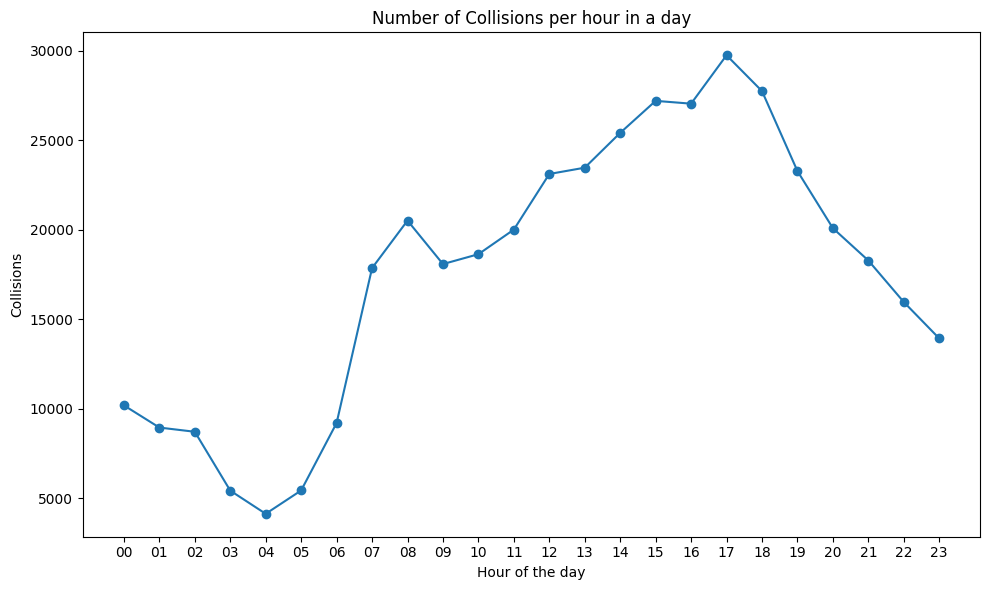

In [9]:
df_hour = df.groupby('Hour').size()
plt.figure(figsize=(10, 6))
plt.plot(df_hour.index, df_hour.values, marker='o')
plt.title('Number of Collisions per hour in a day')
plt.xlabel('Hour of the day')
plt.ylabel('Collisions')
plt.xticks(df_hour.index)
plt.tight_layout()
plt.show()

# **Collision Trend per year**

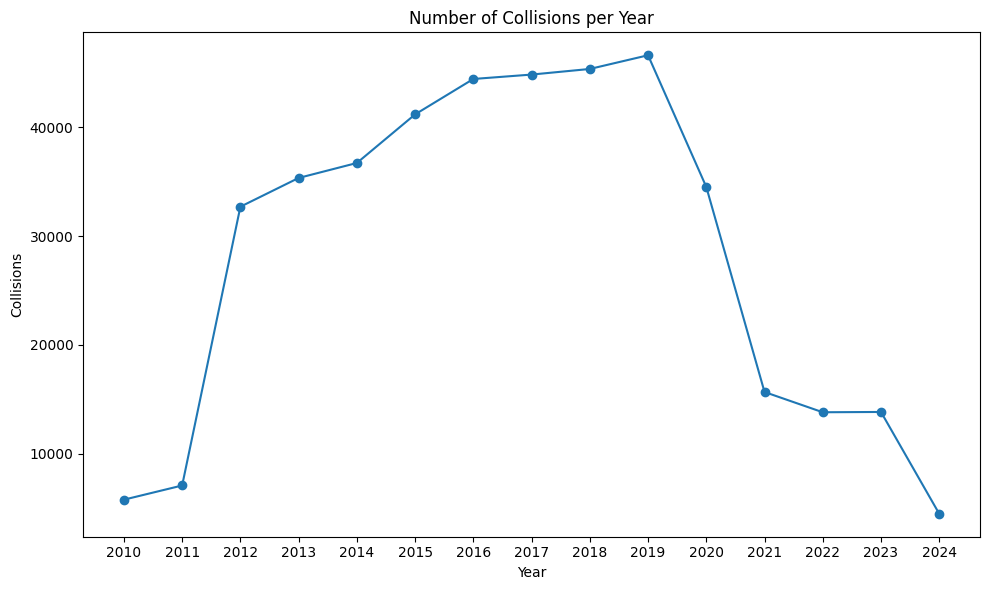

In [10]:
%matplotlib inline
df_year = df.groupby('Oc_Year').size()
plt.figure(figsize=(10, 6))
plt.plot(df_year.index, df_year.values, marker='o')
plt.title('Number of Collisions per Year')
plt.xlabel('Year')
plt.ylabel('Collisions')
plt.xticks(df_year.index)
plt.tight_layout()
plt.show()

# **Collision trend per age group**

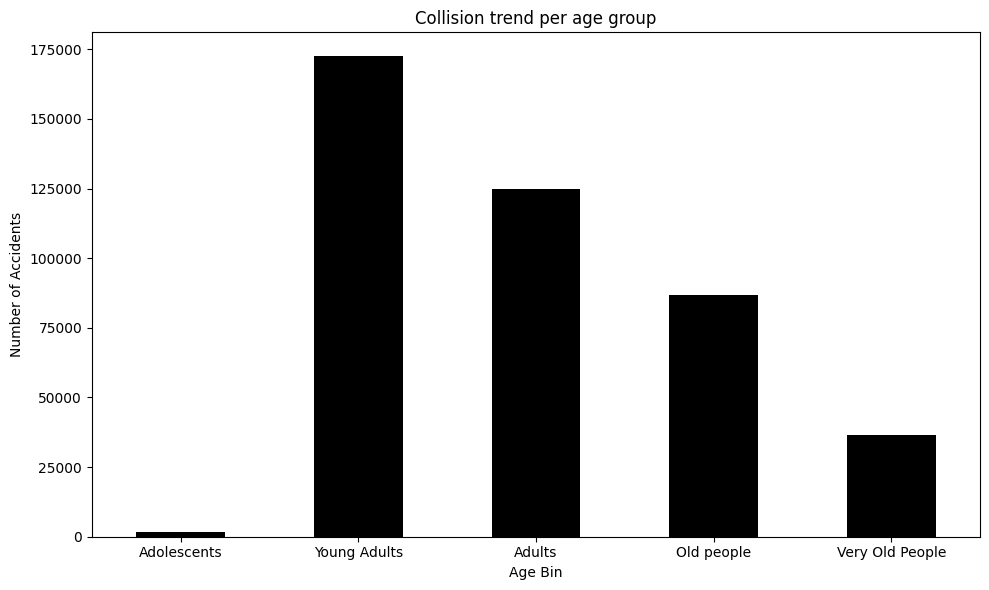

In [11]:
age_bins = [0, 18, 35, 50, 65, float('inf')]
age_labels = ['Adolescents', 'Young Adults', 'Adults', 'Old people', 'Very Old People']
df['Age Bin'] = pd.cut(df['Victim Age'], bins=age_bins, labels=age_labels, right=False)

# Count accidents per age bin
accidents_per_age_bin = df.groupby('Age Bin').size()
plt.figure(figsize=(10, 6))
accidents_per_age_bin.plot(kind='bar', color='black')
plt.title('Collision trend per age group')
plt.xlabel('Age Bin')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# **Collision frequency per location type**

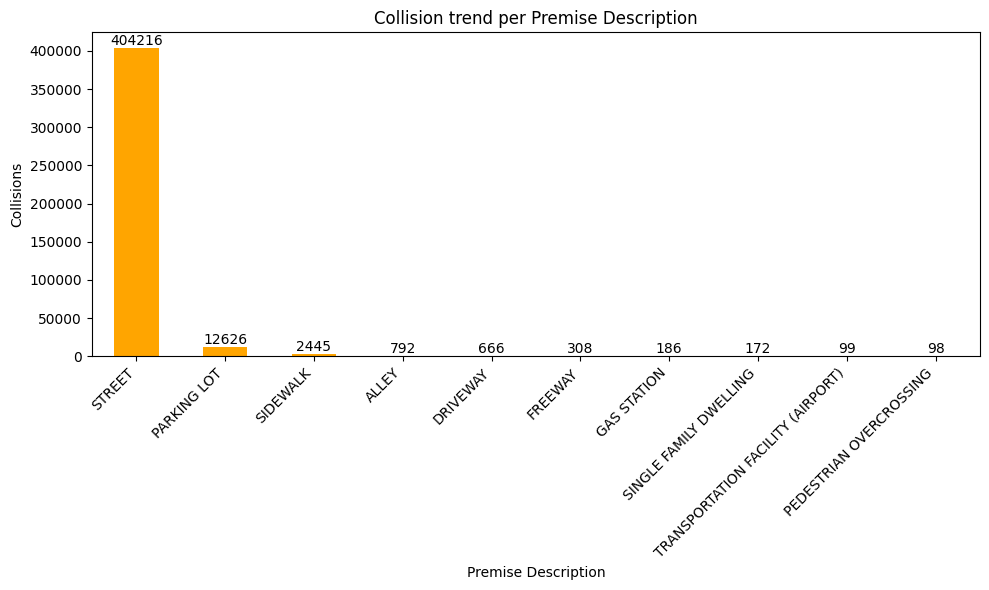

In [12]:
df_loc = df.groupby('Premise Description').size().sort_values(ascending=False)
df_loc_10= df_loc.head(10)
plt.figure(figsize=(10, 6))
df_loc_10.plot(kind='bar', color='orange')
plt.title('Collision trend per Premise Description')
plt.xlabel('Premise Description')
plt.ylabel('Collisions')
for i, value in enumerate(df_loc_10):
    plt.text(i, value + 5, f'{value}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Collision Trend per Gender Type**

Text(0, 0.5, 'Collision Count')

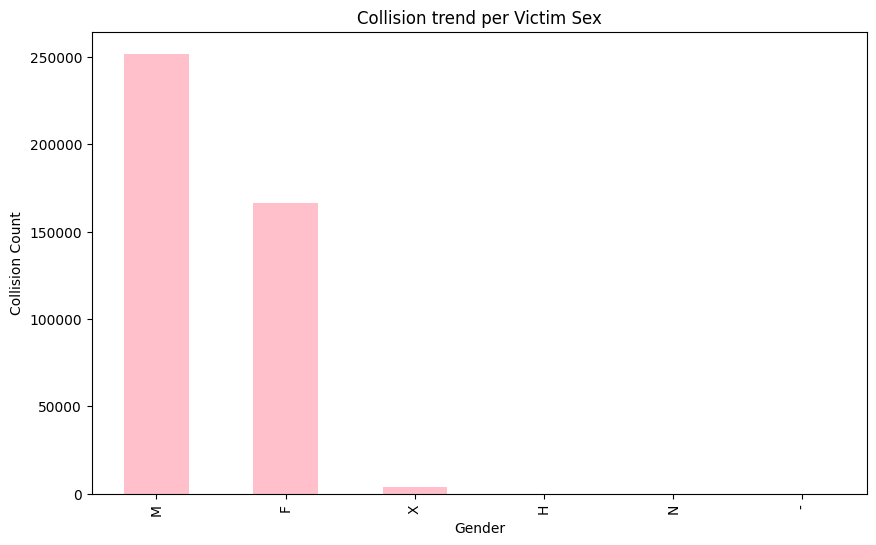

In [13]:
df_gen= df.groupby('Victim Sex').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
df_gen.plot(kind='bar', color='pink')
plt.title('Collision trend per Victim Sex')
plt.xlabel('Gender')
plt.ylabel('Collision Count')

# **Collision Trend per Address Area**

Text(0, 0.5, 'Collision Count')

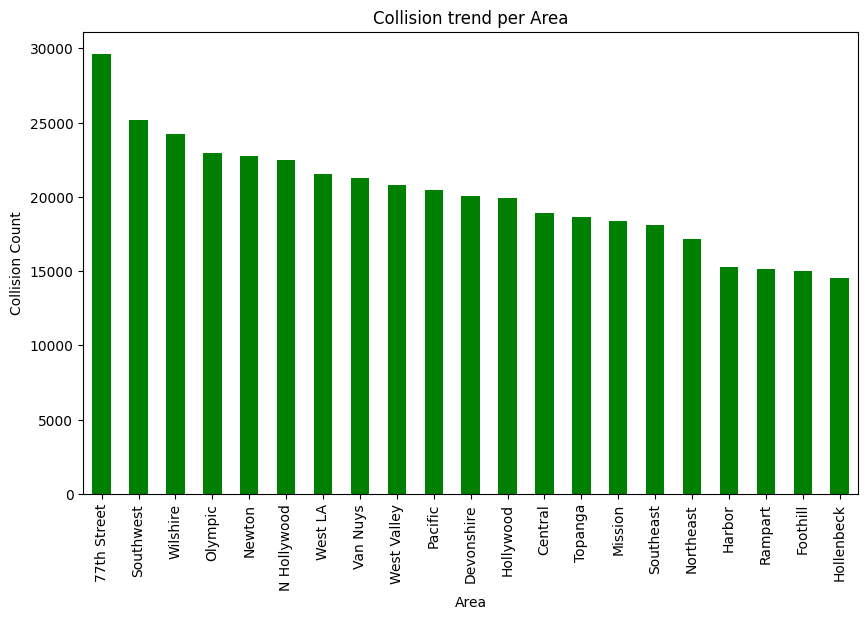

In [14]:
df_area= df.groupby('Area Name').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
df_area.plot(kind='bar', color='green')
plt.title('Collision trend per Area')
plt.xlabel('Area')
plt.ylabel('Collision Count')

In [15]:
df.drop(columns=['Oc_Year','Rep_Year','Age Bin'], inplace=True)

In [16]:
df.head()

,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Hour
0,Southwest,22.0,M,H,STREET,04
1,Southwest,30.0,F,H,STREET,23
3,Central,21.0,M,H,STREET,03
4,Southwest,49.0,M,B,STREET,21
5,Hollenbeck,60.0,M,H,STREET,09


# **Scaling the Data for K Means Clustering**

In [17]:
df = pd.get_dummies(df, columns=['Victim Sex', 'Victim Descent', 'Premise Description', 'Hour', 'Area Name'])
df = df.astype(int)

In [18]:
df.head()

,Victim Age,Victim Sex_-,Victim Sex_F,Victim Sex_H,Victim Sex_M,Victim Sex_N,Victim Sex_X,Victim Descent_-,Victim Descent_A,Victim Descent_B,...,Area Name_Olympic,Area Name_Pacific,Area Name_Rampart,Area Name_Southeast,Area Name_Southwest,Area Name_Topanga,Area Name_Van Nuys,Area Name_West LA,Area Name_West Valley,Area Name_Wilshire
0,22,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,30,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,21,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,60,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
scaler = StandardScaler()
sc = scaler.fit_transform(df)
df_sc= pd.DataFrame(sc, columns=df.columns)
df_sc.head()

,Victim Age,Victim Sex_-,Victim Sex_F,Victim Sex_H,Victim Sex_M,Victim Sex_N,Victim Sex_X,Victim Descent_-,Victim Descent_A,Victim Descent_B,...,Area Name_Olympic,Area Name_Pacific,Area Name_Rampart,Area Name_Southeast,Area Name_Southwest,Area Name_Topanga,Area Name_Van Nuys,Area Name_West LA,Area Name_West Valley,Area Name_Wilshire
0,-1.168418,-0.001539,-0.806141,-0.016505,0.822843,-0.004353,-0.098138,-0.002176,-0.204406,-0.416534,...,-0.239833,-0.225756,-0.192638,-0.211441,3.969239,-0.214805,-0.230119,-0.231678,-0.227742,-0.246675
1,-0.686628,-0.001539,1.240478,-0.016505,-1.215299,-0.004353,-0.098138,-0.002176,-0.204406,-0.416534,...,-0.239833,-0.225756,-0.192638,-0.211441,3.969239,-0.214805,-0.230119,-0.231678,-0.227742,-0.246675
2,-1.228642,-0.001539,-0.806141,-0.016505,0.822843,-0.004353,-0.098138,-0.002176,-0.204406,-0.416534,...,-0.239833,-0.225756,-0.192638,-0.211441,-0.251937,-0.214805,-0.230119,-0.231678,-0.227742,-0.246675
3,0.457625,-0.001539,-0.806141,-0.016505,0.822843,-0.004353,-0.098138,-0.002176,-0.204406,2.400765,...,-0.239833,-0.225756,-0.192638,-0.211441,3.969239,-0.214805,-0.230119,-0.231678,-0.227742,-0.246675
4,1.120088,-0.001539,-0.806141,-0.016505,0.822843,-0.004353,-0.098138,-0.002176,-0.204406,-0.416534,...,-0.239833,-0.225756,-0.192638,-0.211441,-0.251937,-0.214805,-0.230119,-0.231678,-0.227742,-0.246675


# **Deciding how many clusters to use**
By using Elbow Method

In [55]:
inertia = []
K = range(1,11)
for cluster_num in K:
    k_model = KMeans(n_clusters=cluster_num, random_state=42)
    k_model.fit(df_sc)
    inertia.append(k_model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

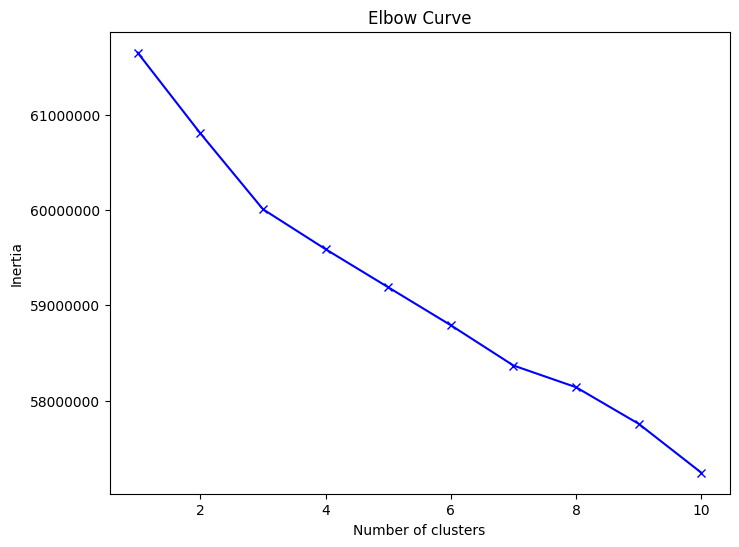

In [56]:
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

Since the elbow forms at K=3, we shall be using 3 clusters for our analysis

# **Fitting a K Means clustering model with 3 clusters**

In [29]:
k_Model_3 = KMeans(n_clusters=3, random_state = 42)
result = k_Model_3.fit(df_sc)
df["clusters"] = result.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
df['clusters'].value_counts().sort_values(ascending=False)

clusters
2    244843
0    159433
1     17980
Name: count, dtype: int64

# **Average Age per cluster**

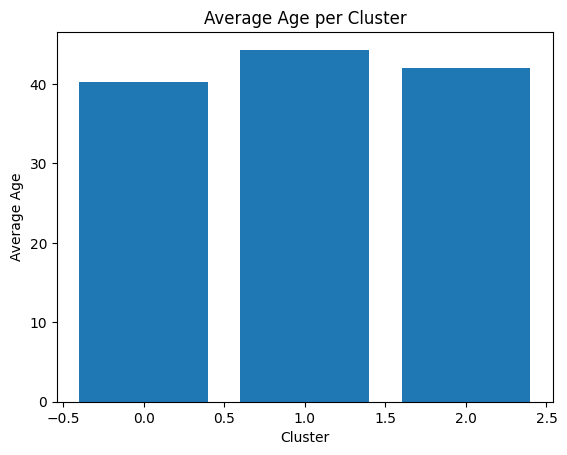

In [46]:
df['clusters']= df['clusters'].astype('category')
age_cl= pd.DataFrame(df.groupby('clusters')['Victim Age'].agg('mean').round(2)).reset_index()
plt.bar(age_cl['clusters'], age_cl['Victim Age'])
plt.title('Average Age per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Age')
plt.show()

# **Number of women per cluster**

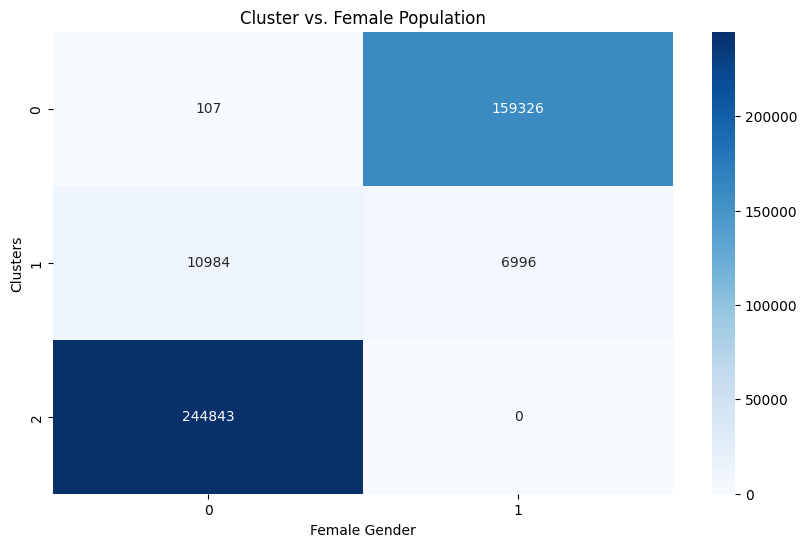

In [58]:
cross_tab_gen= pd.crosstab(df['clusters'], df['Victim Sex_F'])
cross_tab_gen
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_gen, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster vs. Female Population')
plt.xlabel('Female Gender')
plt.ylabel('Clusters')
plt.show()

# **Number of Men per cluster**

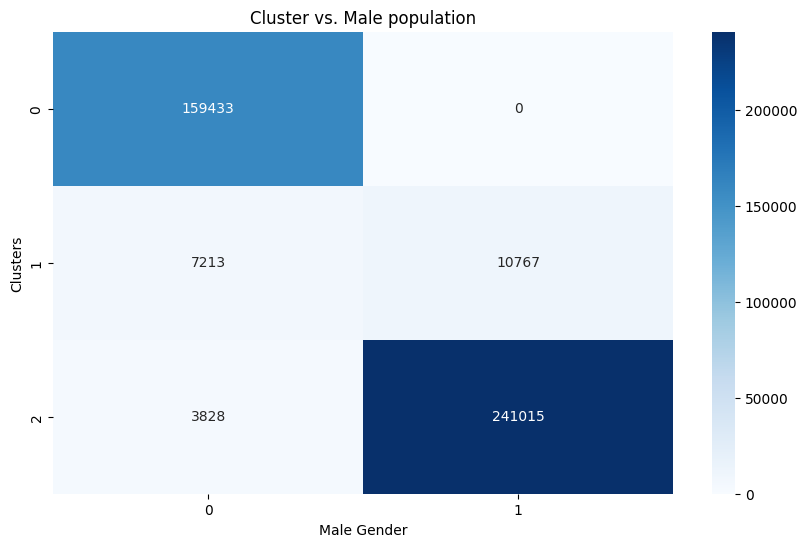

In [57]:
cross_tab_gen= pd.crosstab(df['clusters'], df['Victim Sex_M'])
cross_tab_gen
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_gen, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster vs. Male population')
plt.xlabel('Male Gender')
plt.ylabel('Clusters')
plt.show()

Southwest area population per cluster

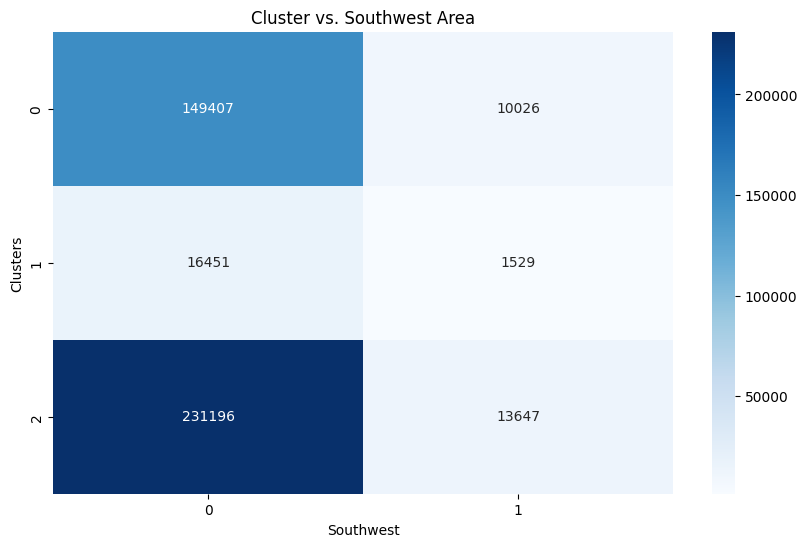

In [54]:
cross_tab_sw= pd.crosstab(df['clusters'], df['Area Name_Southwest'])
cross_tab_sw
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_sw, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster vs. Southwest Area')
plt.xlabel('Southwest')
plt.ylabel('Clusters')
plt.show()